## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, BatchNormalization, Dropout, Flatten, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import os
import ImageController
import Evaluator
import SaveController
import time

## Inspect the data

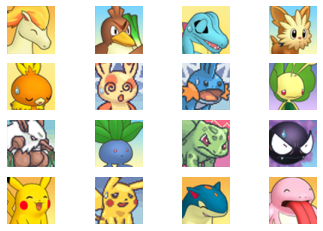

In [2]:
image_dir_url = os.path.join('data', 'smd')

ImageController.plot_random_images(image_dir_url)

## Preprocess the data

In [3]:
train_images = ImageController.load_all_images(image_dir_url).astype('float32')
# Normalize the images to a range from -1 to 1 (subtract half of the maximum value which is 255 from each value)
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

# TODO: Was hat es mit der ersten Methode auf sich?
train_dataset = tf.data.Dataset.from_tensor_slices(tensors=train_images).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)

print('The shape of the dataset:')
train_images.shape

The shape of the dataset:


(4881, 64, 64, 3)

In [4]:
# weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02, mean=0)

## Setting up the generator

In [5]:
def create_generator():
    model = Sequential()

    model.add(InputLayer(input_shape=(128,)))

    # TODO: Warum wird der Bias nicht benötigt? Warum brauchen wir für jeden Graustufen-Wert ein eigenes Feature?
    model.add(Dense(units=4 * 4 * 128, use_bias=False))

    model.add(Reshape(target_shape=(4, 4, 128)))

    model.add(Conv2DTranspose(filters=512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 64, 64, 3)

    return model

In [6]:
NOISE_DIMENSIONS = 128
EXAMPLES_TO_GENERATE = 16

In [7]:
generator = create_generator()

print('The topography of the generator\'s model:')
generator.summary()

The topography of the generator's model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              262144    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normaliza

## Here an example of the output from the untrained generator

In [8]:
# A seed is set so that each time the program is restarted the same vector is created
tf.random.set_seed(0)
# The seed is a pseudo-random vector used throughout the training to generate images and compare the generator's output between different training epochs
seed = tf.random.normal(shape=[EXAMPLES_TO_GENERATE, NOISE_DIMENSIONS])

print('The shape of the seed:')
seed.shape

The shape of the seed:


TensorShape([16, 128])

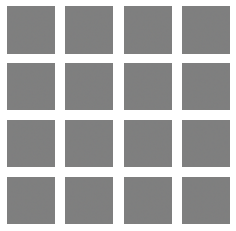

In [9]:
ImageController.generate_and_plot_images(generator, seed)

## Setting up the discriminator model

In [10]:
def create_discriminator():
    # The normal kernel-initializer has standard deviance of 0.01
    # init = RandomNormal(stddev=0.02)

    model = Sequential()

    model.add(InputLayer(input_shape=(64, 64, 3)))

    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate=0.2))

    model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate=0.2))

    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate=0.2))

    model.add(Flatten())

    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [11]:
discriminator = create_discriminator()

print('The topography of the discriminator\'s model:')
discriminator.summary()

The topography of the discriminator's model:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_

## Losses definition

In [12]:
binary_crossentropy = BinaryCrossentropy()

In [13]:
def calc_discriminator_loss(real_output, fake_output):
    y_true_positive = np.ones_like(real_output).flatten()
    y_true_positive = flip_labels(y_true_positive, 0.05)
    y_true_positive = smooth_out_labels(y_true_positive, 0.3)
    y_true_positive = np.reshape(y_true_positive, (-1, 1))

    y_true_negative = np.zeros_like(fake_output).flatten()
    y_true_negative = flip_labels(y_true_negative, 0.05)
    y_true_negative = smooth_out_labels(y_true_negative, 0.3)
    y_true_negative = np.reshape(y_true_negative, (-1, 1))

    real_loss = binary_crossentropy(y_true=y_true_positive, y_pred=real_output)
    fake_loss = binary_crossentropy(y_true=y_true_negative, y_pred=fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
# If the generator does a good job the discriminator will classify the image as real  (i.e. as 1). Therefore for generator loss y_true is 1.
def calc_generator_loss(fake_output):
    return binary_crossentropy(y_true=tf.ones_like(fake_output), y_pred=fake_output)

In [15]:
def smooth_out_labels(labels, smoothness_range):
    for i, label in enumerate(labels):
        if label == 0:
            labels[i] = np.random.random() * smoothness_range
        elif label == 1:
            labels[i] = 1 - np.random.random() * smoothness_range
    return labels

In [16]:
def flip_labels(labels, flip_probability):
    for i, label in enumerate(labels):
        if flip_probability > np.random.random():
            labels[i] = 0 if label == 1 else 1
    return labels

## Optimizers definition

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

## Training functions definition

In [18]:
def train_iteration(images_batch, is_last_iteration_in_epoch: bool):
    noise = tf.random.normal(shape=[BATCH_SIZE, NOISE_DIMENSIONS])

    # TODO: Was ist ein GradientTape?
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images_batch = generator(noise, training=True)

        real_output = discriminator(images_batch)
        fake_output = discriminator(generated_images_batch)

        generator_loss = calc_generator_loss(fake_output)
        discriminator_loss = calc_discriminator_loss(real_output, fake_output)

        # if is_last_iteration_in_epoch:
        #     plt.figure(figsize=(4, 8))
        #     plt.subplot(1, 2, 1)
        #     plt.title('Real: 1; Pred: {:.2f}'.format(real_output.numpy()[0][0]))
        #     real_image = images_batch[0].numpy() * 127.5 + 127.5
        #     real_image = real_image.astype('uint8')
        #     plt.imshow(real_image)
        #     plt.subplot(1, 2, 2)
        #     plt.title('Real: 0; Pred: {:.2f}'.format(fake_output.numpy()[0][0]))
        #     generated_image = generated_images_batch[0].numpy() * 127.5 + 127.5
        #     generated_image = generated_image.astype('uint8')
        #     plt.imshow(generated_image)
        #     plt.show()


    gradients_of_generator = gen_tape.gradient(target=generator_loss, sources=generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(target=discriminator_loss, sources=discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_output, fake_output, discriminator_loss, generator_loss

In [19]:
def train(image_dataset, epochs, generated_images_dir_url: str, generated_figures_dir_url: str):
    training_start = time.time()
    print('\nTRAINING STARTED')

    generator_losses = []
    discriminator_losses = []
    discriminator_accuracies = []

    for epoch in epochs:
        epoch_start = time.time()

        for i, image_batch in enumerate(image_dataset):
            is_last_iteration_in_epoch = i == len(image_dataset) - 1
            real_output, fake_output, discriminator_loss, generator_loss = train_iteration(image_batch, is_last_iteration_in_epoch)

            # At each epochs' last iteration the current metrics should be saved for future analysis
            if i == len(image_dataset) - 1:
                generator_losses.append(generator_loss)
                discriminator_losses.append(discriminator_loss)

                y_true = np.append(np.ones_like(real_output), np.zeros_like(fake_output))
                y_pred = np.append(real_output, fake_output)
                discriminator_accuracy = binary_accuracy(y_true, y_pred)
                discriminator_accuracies.append(discriminator_accuracy)

        ImageController.generate_and_save_images(generator, seed, os.path.join(generated_images_dir_url, f'images-at-epoch-{epoch}'))
        SaveController.save_checkpoint_weights(epoch, generator, discriminator, generator_checkpoints_dir_url, discriminator_checkpoints_dir_url, generator_losses[-1], discriminator_losses[-1])

        epoch_end = time.time()

        print(f'\nTime for epoch {epoch}: {epoch_end - epoch_start} sec')
        print(f'Generator loss: {generator_losses[-1]}; Discriminator loss: {discriminator_losses[-1]}; Discriminator Accuracy: {discriminator_accuracies[-1]}')

    Evaluator.plot_and_save_losses(generator_losses, discriminator_losses, epochs, generated_figures_dir_url)
    Evaluator.plot_and_save_discriminator_accuracies(discriminator_accuracies, epochs, generated_figures_dir_url)

    training_end = time.time()

    print(f'\nTotal time: {(training_end - training_start)/60} min\n')
    print('TRAINING COMPLETED')

## Hyperparameters

In [20]:
end_epoch = 10

# URLs
generator_checkpoints_dir_url = os.path.join('checkpoints', 'generator')
discriminator_checkpoints_dir_url = os.path.join('checkpoints', 'discriminator')
# Directory which stores all generated media in its subdirectories (i.e. the generated Pokémon from the seed, the gif which shows the progress throughout all epochs and the evaluation figures constructed at the end of the training)
generated_media_dir_url = 'generated-media'

# Controls whether previously saved checkpoint files should be used or not
should_use_checkpoint_files = False

## Actual training

Found previously saved checkpoint files
Will not be using previous checkpoint files because should_use_checkpoint_files is set to: False
Previous checkpoint files have been deleted
Generated images will be saved after each epoch at:
generated-media\2021-01-08T16-14-51+0100\images
GIF consisting of all generated images will be saved after training at:
generated-media\2021-01-08T16-14-51+0100\gifs
Starting training from epoch 0. Remaining epochs: 10

TRAINING STARTED

Time for epoch 1: 8.271298885345459 sec
Generator loss: 0.8538422584533691; Discriminator loss: 1.2697277069091797; Discriminator Accuracy: 0.865234375

Time for epoch 2: 7.53662109375 sec
Generator loss: 1.066815733909607; Discriminator loss: 1.213002324104309; Discriminator Accuracy: 0.841796875

Time for epoch 3: 7.4851789474487305 sec
Generator loss: 1.0414906740188599; Discriminator loss: 1.2264666557312012; Discriminator Accuracy: 0.80859375

Time for epoch 4: 7.7874391078948975 sec
Generator loss: 0.8799654841423035;

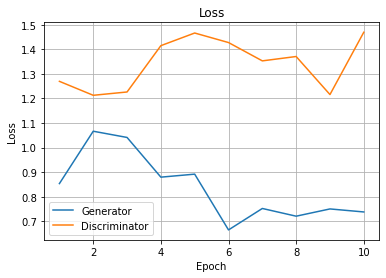

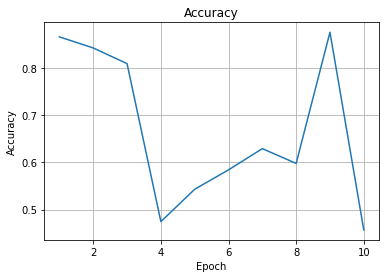

In [21]:
do_checkpoint_files_exist = SaveController.do_checkpoint_files_exist(generator_checkpoints_dir_url, discriminator_checkpoints_dir_url)

if do_checkpoint_files_exist:
    print('Found previously saved checkpoint files')
    if should_use_checkpoint_files:
        print(f'Will be using previous checkpoint files because should_use_checkpoint_files is set to: {should_use_checkpoint_files}')
        last_created_generated_media_subdir_url = SaveController.get_last_created_subdir_url(generated_media_dir_url)
        generated_images_dir_url = os.path.join(last_created_generated_media_subdir_url, 'images')
        generated_gifs_dir_url = os.path.join(last_created_generated_media_subdir_url, 'gifs')
        generated_figures_dir_url = os.path.join(last_created_generated_media_subdir_url, 'figures')
        last_completed_epoch = SaveController.load_latest_checkpoint_files(generator, discriminator, generator_checkpoints_dir_url, discriminator_checkpoints_dir_url)
        start_epoch = last_completed_epoch + 1
    else:
        print(f'Will not be using previous checkpoint files because should_use_checkpoint_files is set to: {should_use_checkpoint_files}')
        SaveController.delete_checkpoint_files(generator_checkpoints_dir_url, discriminator_checkpoints_dir_url)
        print('Previous checkpoint files have been deleted')

        generated_images_dir_url, generated_gifs_dir_url, generated_figures_dir_url = SaveController.get_new_generated_media_subdir_urls(generated_media_dir_url)
        SaveController.create_generated_media_dirs(generated_images_dir_url, generated_gifs_dir_url, generated_figures_dir_url)
        start_epoch = 0
else:
    print('Did not find any previously saved checkpoint files')
    generated_images_dir_url, generated_gifs_dir_url, generated_figures_dir_url = SaveController.get_new_generated_media_subdir_urls(generated_media_dir_url)
    SaveController.create_generated_media_dirs(generated_images_dir_url, generated_gifs_dir_url, generated_figures_dir_url)
    SaveController.create_checkpoint_dirs(generator_checkpoints_dir_url, discriminator_checkpoints_dir_url)
    start_epoch = 0


print(f'Starting training from epoch {start_epoch}. Remaining epochs: {end_epoch - start_epoch}')
train(train_dataset, range(start_epoch + 1, end_epoch + 1), generated_images_dir_url, generated_figures_dir_url)

In [22]:
ImageController.create_and_save_gif(image_dir_url=generated_images_dir_url, output_url=os.path.join(generated_gifs_dir_url, 'pokegan.gif'))

Saved gif at: generated-media\2021-01-08T16-14-51+0100\gifs\pokegan.gif
